#1. Data Ingestion and Structural Inspection


In [3]:
import pandas as pd


df = pd.read_csv("/content/Sepsis Prediction.csv")


if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])


df = df.rename(columns={
    "Patient_ID": "patient_id",
    "Hour": "icu_hour"
})


df["icu_hour"] = pd.to_numeric(df["icu_hour"], errors="coerce")

print(df.shape)
print(df.columns)
print(df.head())


(1552210, 43)
Index(['icu_hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel', 'patient_id'],
      dtype='object')
   icu_hour    HR  O2Sat  Temp    SBP   MAP   DBP  Resp  EtCO2  BaseExcess  \
0         0   NaN    NaN   NaN    NaN   NaN   NaN   NaN    NaN         NaN   
1         1  65.0  100.0   NaN    NaN  72.0   NaN  16.5    NaN         NaN   
2         2  78.0  100.0   NaN    NaN  42.5   NaN   NaN    NaN         NaN   
3         3  73.0  100.0   NaN    NaN   NaN   NaN  17.0    NaN         NaN   
4         4  70.0  100.0   NaN  129.0  74.0  69.0  14.0    NaN         NaN

#2. Temporal Alignment and Patient-Level Ordering

In [4]:
df = df.sort_values(
    by=["patient_id", "icu_hour"],
    kind="mergesort"
).reset_index(drop=True)

print(df["SepsisLabel"].value_counts())



SepsisLabel
0    1524294
1      27916
Name: count, dtype: int64


#3. Prospective Early Warning Label Construction

In [5]:
import numpy as np

HORIZON = 6  # hours ahead

df["EW_Label"] = 0

for pid, g in df.groupby("patient_id", sort=False):
    sepsis_hours = g.loc[g["SepsisLabel"] == 1, "icu_hour"].values
    if sepsis_hours.size == 0:
        continue

    hours = g["icu_hour"].values
    next_sepsis = np.full_like(hours, np.inf, dtype=float)

    for t in sepsis_hours:
        next_sepsis = np.minimum(next_sepsis, t - hours)

    ew_mask = (next_sepsis > 0) & (next_sepsis <= HORIZON)
    df.loc[g.index, "EW_Label"] = ew_mask.astype(int)

print(df["EW_Label"].value_counts())



EW_Label
0    1538131
1      14079
Name: count, dtype: int64


#4. Feature Definition and Cohort Construction

In [6]:
feature_cols = [
    'HR','O2Sat','Temp','SBP','MAP','DBP','Resp','EtCO2',
    'BaseExcess','HCO3','FiO2','pH','PaCO2','SaO2','AST',
    'BUN','Alkalinephos','Calcium','Chloride','Creatinine',
    'Bilirubin_direct','Glucose','Lactate','Magnesium',
    'Phosphate','Potassium','Bilirubin_total','TroponinI',
    'Hct','Hgb','PTT','WBC','Fibrinogen','Platelets',
    'Age','Gender'
]


# 5. Patient-Level Train–Test Partitioning

In [7]:
from sklearn.model_selection import train_test_split

patients = df["patient_id"].unique()

train_p, test_p = train_test_split(
    patients,
    test_size=0.2,
    random_state=42
)

train_idx = df["patient_id"].isin(train_p)
test_idx  = df["patient_id"].isin(test_p)

X_train = df.loc[train_idx, feature_cols]
y_train = df.loc[train_idx, "EW_Label"]

X_test  = df.loc[test_idx, feature_cols]
y_test  = df.loc[test_idx, "EW_Label"]

# 6. Missing-Value Imputation and Feature Preparation

In [8]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

X_train = pd.DataFrame(
    imputer.fit_transform(X_train),
    columns=feature_cols
)

X_test = pd.DataFrame(
    imputer.transform(X_test),
    columns=feature_cols
)

print(X_train.shape, X_test.shape)
print(y_train.value_counts())
print(y_test.value_counts())


(1241213, 36) (310997, 36)
EW_Label
0    1229768
1      11445
Name: count, dtype: int64
EW_Label
0    308363
1      2634
Name: count, dtype: int64


# 7. Gradient Boosted Tree Model Development

In [9]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, average_precision_score

train_data = lgb.Dataset(X_train, label=y_train)
test_data  = lgb.Dataset(X_test, label=y_test)

params = {
    "objective": "binary",
    "metric": ["auc", "average_precision"],
    "learning_rate": 0.05,
    "num_leaves": 64,
    "max_depth": 7,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "is_unbalance": True,
    "verbosity": -1,
    "seed": 42
}

model = lgb.train(
    params,
    train_data,
    num_boost_round=500,
    valid_sets=[train_data, test_data],
    valid_names=["train", "test"],
    callbacks=[
        lgb.early_stopping(50),
        lgb.log_evaluation(50)
    ]
)

Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.713655	train's average_precision: 0.0268583	test's auc: 0.647388	test's average_precision: 0.0158643
[100]	train's auc: 0.740492	train's average_precision: 0.0367332	test's auc: 0.647494	test's average_precision: 0.016047
Early stopping, best iteration is:
[77]	train's auc: 0.728721	train's average_precision: 0.0319378	test's auc: 0.648488	test's average_precision: 0.0161258


# 8. Discriminative Performance Evaluation

In [10]:
y_pred = model.predict(X_test)

roc = roc_auc_score(y_test, y_pred)
pr  = average_precision_score(y_test, y_pred)

print(f"Test AUROC: {roc:.4f}")
print(f"Test PR-AUC: {pr:.4f}")



Test AUROC: 0.6485
Test PR-AUC: 0.0161


In [ ]:
y_pred_proba = bst.predict(X_test)


#9. Global Model Interpretability Analysis

/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


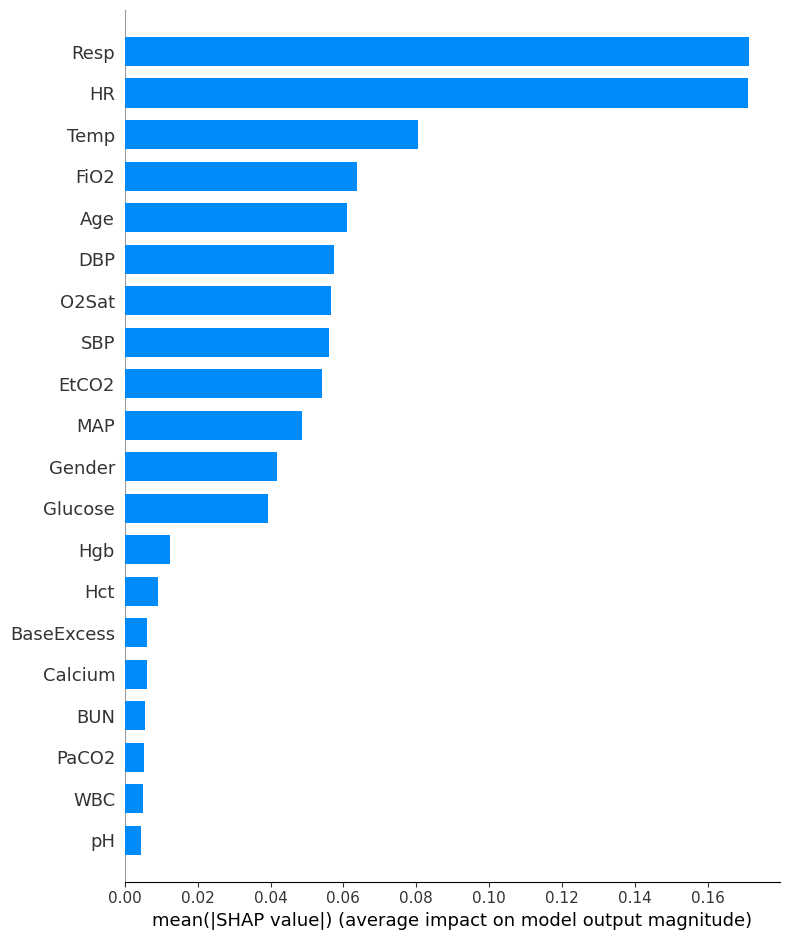

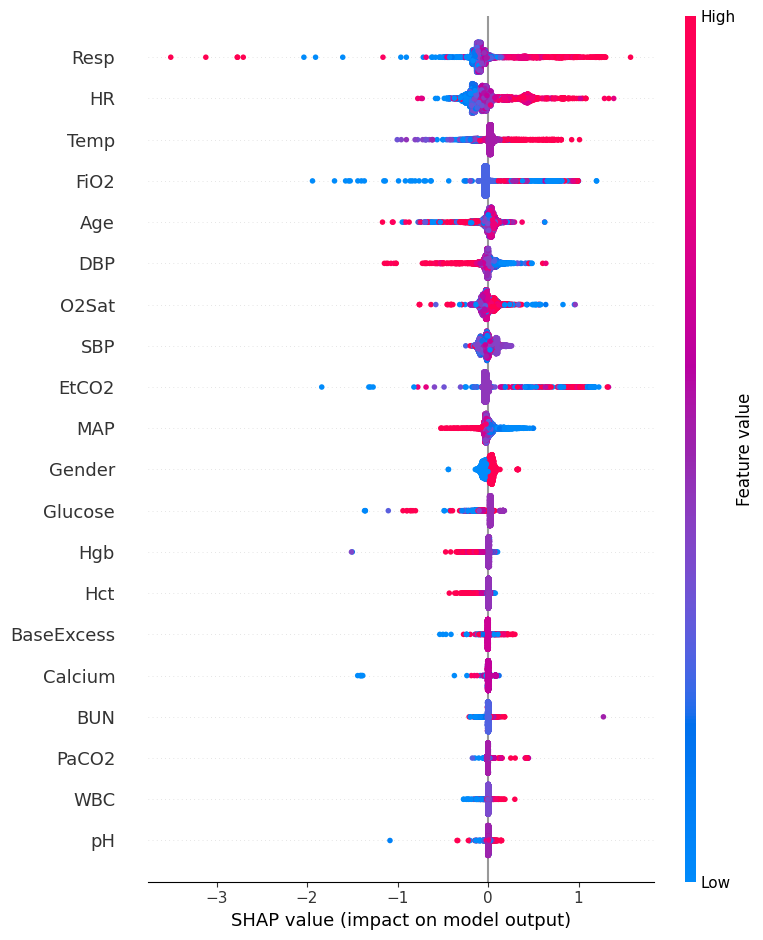

In [11]:
import shap

explainer = shap.TreeExplainer(model)

X_sample = X_test.sample(5000, random_state=42)
shap_values = explainer.shap_values(X_sample)

shap_vals = shap_values[0] if isinstance(shap_values, list) else shap_values

shap.summary_plot(shap_vals, X_sample, plot_type="bar")
shap.summary_plot(shap_vals, X_sample)

#10. Local Explanation of Individual Risk Trajectories

/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


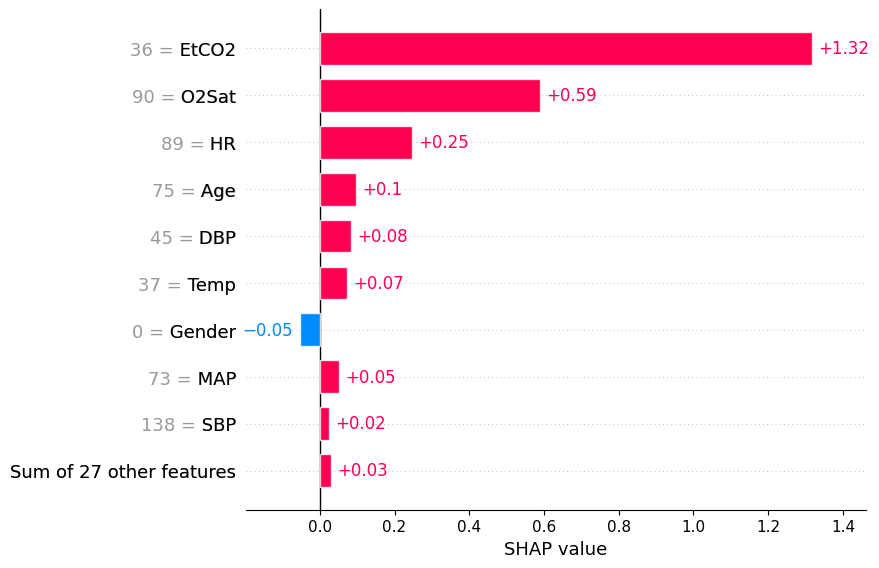

In [14]:
import numpy as np
import shap

# pick highest-risk prediction
idx = np.argmax(y_pred)
patient = X_test.iloc[[idx]]


shap_values = explainer.shap_values(patient)


if isinstance(shap_values, list):
    shap_vals = shap_values[1]
else:
    shap_vals = shap_values


expected_val = explainer.expected_value
if isinstance(expected_val, (list, np.ndarray)):
    expected_val = expected_val[1]


shap_expl = shap.Explanation(
    values=shap_vals[0],
    base_values=expected_val,
    data=patient.iloc[0],
    feature_names=patient.columns
)


shap.plots.bar(shap_expl, max_display=10)

#11. Threshold-Based Clinical Decision Analysis (Baseline)

In [15]:
from sklearn.metrics import confusion_matrix, classification_report

threshold = 0.5
y_pred_cls = (y_pred >= threshold).astype(int)

print(confusion_matrix(y_test, y_pred_cls))
print(classification_report(y_test, y_pred_cls, digits=4))


[[222517  85846]
 [  1355   1279]]
              precision    recall  f1-score   support

           0     0.9939    0.7216    0.8362    308363
           1     0.0147    0.4856    0.0285      2634

    accuracy                         0.7196    310997
   macro avg     0.5043    0.6036    0.4323    310997
weighted avg     0.9857    0.7196    0.8293    310997



#12. Clinical Utility and Risk Stratification Analysis

In [16]:
import pandas as pd

risk_df = pd.DataFrame({
    "risk_score": y_pred,
    "EW_Label": y_test.values
})


risk_df["risk_group"] = pd.qcut(
    risk_df["risk_score"],
    q=[0, 0.8, 0.95, 1.0],
    labels=["Low risk", "Intermediate risk", "High risk"]
)

summary = risk_df.groupby("risk_group").agg(
    prevalence=("EW_Label", "mean"),
    count=("EW_Label", "size")
)

print(summary)


                   prevalence   count
risk_group                           
Low risk             0.006632  248797
Intermediate risk    0.013183   46650
High risk            0.023730   15550


/tmp/ipython-input-3722517483.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = risk_df.groupby("risk_group").agg(
